In [103]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [104]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
test = pd.read_csv('data/WSJ_24.pos', sep='\t', header=0, names=['word', 'pos'])
train.head()

In [106]:
sequence_length = 5 # centre word, 2 before and 2 afer

In [107]:
input_data = []
for tup in train.itertuples(index=False, name=None):
    input_data.append(tup)
input_data[:10]

[('an', 'DT'),
 ('Oct.', 'NNP'),
 ('19', 'CD'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('``', '``'),
 ('The', 'DT'),
 ('Misanthrope', 'NN'),
 ("''", "''"),
 ('at', 'IN')]

In [108]:
matrix = []
for index in range(len(input_data)):
    if index+sequence_length>len(input_data):
        break
    matrix.append(input_data[index:index+sequence_length])
    index+=sequence_length

In [142]:
suffixes = []
for item in set(train['word']):
    suffixes.append(item[-3:])
    
initial_letters = []
for item in set(train['word']):
    initial_letters.append(item[0])
    
pos_vocab = set(train['pos'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}

word_vocab = set(train['word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

word_vocab.update(initial_letters)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = {v:k for k, v in index_to_word.items()}

print(len(word_vocab), len(pos_vocab))

44389
47551
47570


In [149]:
transformed_matrix = []

for row in matrix:
    features = []

    features.append(pos_to_index[row[1][1]])
    features.append(pos_to_index[row[0][1]])

    features.append(word_to_index[row[2][0][-3:]])
    features.append(word_to_index[row[2][0][0]])
    features.append(word_to_index[row[2][0]])
    features.append(word_to_index[row[1][0]])
    features.append(word_to_index[row[1][0][-3:]])
    features.append(word_to_index[row[0][0]])
    features.append(word_to_index[row[3][0]])    
    features.append(word_to_index[row[3][0][-3:]])    
    features.append(word_to_index[row[4][0]])
    features.append(pos_to_index[row[2][1]])
    
    transformed_matrix.append(features)  

In [153]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=11))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(pos_vocab), activation='sigmoid'))

    return model

In [154]:
model = get_model(len(word_vocab)+len(pos_vocab), 100)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 11, 100)           4761500   
_________________________________________________________________
flatten_5 (Flatten)          (None, 1100)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 45)                49545     
Total params: 4,811,045
Trainable params: 4,811,045
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalCrossentropy(), keras.metrics.CategoricalAccuracy()])

In [220]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(pos_vocab))
X.shape, y.shape

((950023, 11), (950023, 45))

In [182]:
X_train = X[:10000]
X_test = X[10000:11000]

y_train = y[:10000]
y_test = y[10000:11000]

In [183]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=3)

Epoch 1/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0249 - categorical_crossentropy: 0.0249 - categorical_accuracy: 0.9972 - val_loss: 0.2598 - val_categorical_crossentropy: 0.2598 - val_categorical_accuracy: 0.9280
Epoch 2/5
313/313 [==============================] - 13s 43ms/step - loss: 0.0157 - categorical_crossentropy: 0.0157 - categorical_accuracy: 0.9987 - val_loss: 0.2606 - val_categorical_crossentropy: 0.2606 - val_categorical_accuracy: 0.9290
Epoch 3/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0103 - categorical_crossentropy: 0.0103 - categorical_accuracy: 0.9993 - val_loss: 0.2623 - val_categorical_crossentropy: 0.2623 - val_categorical_accuracy: 0.9280
Epoch 4/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0072 - categorical_crossentropy: 0.0072 - categorical_accuracy: 0.9995 - val_loss: 0.2624 - val_categorical_crossentropy: 0.2624 - val_categorical_accuracy: 0.9280
Epoch 5/5
313/313 [=================

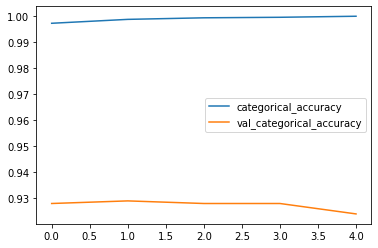

In [185]:
for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [216]:
model.save('data/model/')

INFO:tensorflow:Assets written to: data/model/assets


In [215]:
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9801980198019802
0.9502487562189055
0.9335548172757475
0.9251870324189526
0.9121756487025948
0.9234608985024958
0.9258202567760342
0.9250936329588015
0.9245283018867925
